In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [14]:
def oracle(x, theta=1, bias=0., noise_std=0.):
    return np.sin(theta * x) + bias + noise_std * np.random.randn(*x.shape)

In [188]:
# Data
N = 10
sigma = 0.5
theta_star = 3
bias_star = -0.2
X_train = 10 * np.random.rand(N, 1)
Y_train = oracle(X_train, theta_star, bias_star, noise_std=sigma)

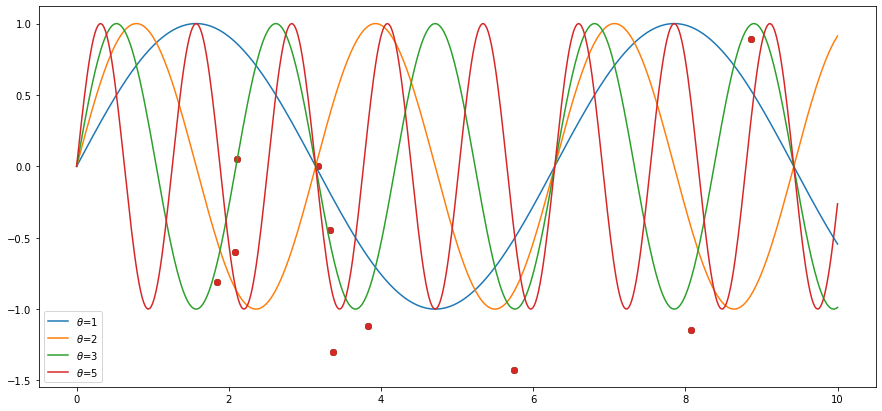

In [189]:
x = np.linspace(0, 10, 500)
plt.figure(figsize=(15, 7))
for theta in (1, 2, 3, 5):
    plt.plot(x, oracle(x, theta), label=r'$\theta$={}'.format(theta))
    plt.scatter(X_train, Y_train)
plt.legend()
plt.show()

In [253]:
# Prior theta ~ U({2.5, 2.6, ..., 3.5}), bias ~ U({-0.5, -0.4, ..., 0.5})
biaseS = 1./10 * (np.arange(11) - 5)
thetaS = 1./ 10 * np.arange(11) + 2.5
def likelihood_fn(x, y, theta, bias):
    # evaluates P(data = {x, y} | theta)
    to_exp = -0.5 / sigma ** 2 * ( y - oracle(x, theta, bias) ) ** 2
    likelihoods = 1. / np.sqrt(2 * np.pi * sigma ** 2) * np.exp(to_exp)
    return np.prod(likelihoods)

In [191]:
def posterior_numerator(x, y, theta, bias):
    prior = 1./11**2
    likelihood = likelihood_fn(x, y, theta, bias)
    numerator = prior * likelihood
    return numerator

def posterior(x, y, theta, bias):
    denominator = np.sum([np.sum([posterior_numerator(x, y, theta, bias) for bias in biases]) for theta in thetas])
    return posterior_numerator(x, y, theta, bias) / denominator

def torch_posterior_numerator(XY, thetabias):
    # XY is of size N x 2
    # thetabias is of size M x 2
    tb = thetabias.unsqueeze(0).repeat(XY.shape[0], 1, 1).transpose(0, 1)
    to_exp = -0.5 / sigma ** 2 * (XY[:, 1] - torch.sin(tb[:,:, 0] * XY[:, 0]) - tb[:,:, 1]) ** 2
    likelihoods = 1. / np.sqrt(2 * np.pi * sigma ** 2) * torch.exp(to_exp)
    likelihoods = torch.prod(likelihoods, dim=1)
    return 1./11**2 * likelihoods

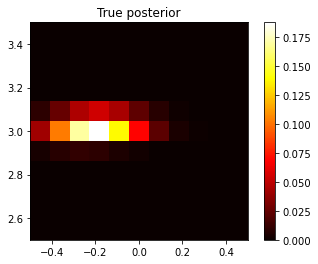

In [197]:
plt.imshow(np.array([[posterior(X_train, Y_train, theta, bias) for bias in biases] for theta in thetas]), cmap='hot', interpolation='nearest',
          extent=[-0.5, 0.5, 2.5, 3.5])
plt.colorbar()
plt.title('True posterior')
plt.show()

In [198]:
import torch
import torch.nn as nn

In [577]:
class CGFN(nn.Module):
    def __init__(self, emb_size=16):
        super().__init__()
        self.data_emb = nn.Sequential(nn.Linear(2, 128),
                                     nn.ReLU(),
                                     nn.Linear(128, 128),
                                     nn.ReLU(),
                                     nn.Linear(128, emb_size))
        
        self.flow_net_1 = nn.Linear(emb_size + 1, 128)
        self.flow_net_2 = nn.Linear(emb_size + 2, 128)
        
        self.flow_net_torso = nn.Sequential(
                                     nn.ReLU(),
                                     nn.Linear(128, 128),
                                     nn.ReLU(),
                                     nn.Linear(128, 1),
                                     )
        
        self.fprob_net = nn.Sequential(  nn.Linear(emb_size + 1, 128),
                                     nn.ReLU(),
                                     nn.Linear(128, 128),
                                     nn.ReLU(),
                                     nn.Linear(128, 11),
                                     nn.LogSoftmax()
                                     )
        
        
        
    def forward(self, data, thetabias):
        # data should be a n x 2 tensor of input outputs
        # thetabias should be a M x 2 tensor or M x 1
        embs = self.data_emb(data)
        emb = embs.mean(0).unsqueeze(0).repeat(thetabias.shape[0], 1)
        inputs = torch.cat((thetabias, emb), 1)
        flow_beginning = self.flow_net_1(inputs) if thetabias.shape[1] == 1 else self.flow_net_2(inputs)
        return self.flow_net_torso(flow_beginning)  # M x 1
    
    def fprob(self, data, thetas):
        # thetabias should be a M x 1 tensor
        embs = self.data_emb(data)
        emb = embs.mean(0).unsqueeze(0).repeat(thetas.shape[0], 1)
        return self.fprob_net(torch.cat((thetas, emb), 1))  # M x 11

In [578]:
F = CGFN().to(torch.double)
XY = torch.cat((torch.tensor(X_train), torch.tensor(Y_train)), 1)
optimizer = torch.optim.Adam(F.parameters(), lr=5e-3)

In [541]:
# Training policy: uniform in thetas x biases
losses = []
losses_db = []
losses_r = []
epochs = 2000
BS = 10
delta = 1e-30
lamda = .5
for epoch in range(epochs):
    optimizer.zero_grad()
    # sample a subdataset
    n = np.random.randint(1, N + 1)
    data = XY#[torch.randperm(N)[:n]]
    
    # sample a thetabias
    theta_batch = np.random.choice(thetas, BS)
    bias_batch = np.random.choice(biases, BS)
    # thetabiases = torch.cat((torch.tensor(theta_batch).unsqueeze(-1), torch.tensor(bias_batch).unsqueeze(-1)), 1)
    thetabiases = torch.FloatTensor([[theta, bias] for theta in thetaS for bias in biaseS])
    thetas = thetabiases[:, 0]
    
    # fprob 
    fprob = F.fprob(data, thetabs)  # M x 1
    theta_flow = F(data, thetas.unsqueeze(-1))
    thetabias_flow = F(data, thetabiases)
    loss_db = nn.MSELoss()(fprob + theta_flow, thetabias_flow) # need to fix this !! should select the corresponding columns from fprob
    loss_reward = nn.MSELoss()(thetabias_flow, torch.log(delta + torch_posterior_numerator(data, thetabiases).unsqueeze(-1)))
    loss = lamda * loss_db + loss_reward
    losses.append(loss.item())
    losses_db.append(loss_db.item())
    losses_r.append(loss_reward.item())
    loss.backward()
    optimizer.step()

In [593]:
F.fprob(XY, thetas[:5,:])

tensor([[-2.1947, -2.3073, -2.5584, -2.2528, -2.4626],
        [-2.1889, -2.3048, -2.5597, -2.2505, -2.4673],
        [-2.1830, -2.3027, -2.5610, -2.2484, -2.4720],
        [-2.1771, -2.3007, -2.5624, -2.2461, -2.4767],
        [-2.1713, -2.2986, -2.5641, -2.2439, -2.4813]], dtype=torch.float64,
       grad_fn=<IndexBackward>)

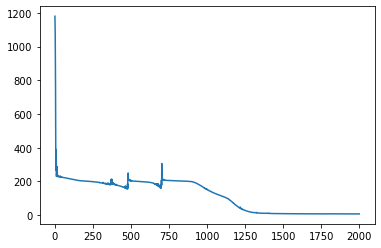

In [542]:
plt.plot(losses_r)

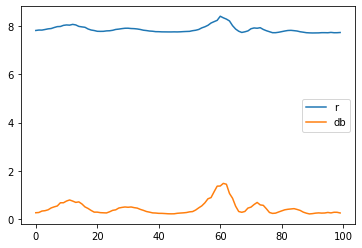

In [543]:
plt.plot(losses_r[-100:], label='r')
plt.plot(losses_db[-100:], label='db')
plt.legend()
plt.show()

In [544]:
thetabiases = torch.FloatTensor([[theta, bias] for theta in thetaS for bias in biaseS])

In [545]:
flows = F(XY, thetabiases).view(11, 11).detach()

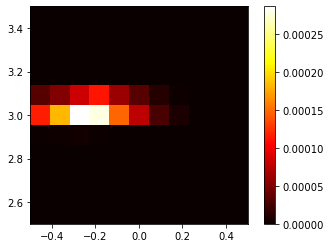

In [546]:
plt.imshow(torch.exp(flows).numpy(), cmap='hot', interpolation='nearest',
          extent=[-0.5, 0.5, 2.5, 3.5])
plt.colorbar()

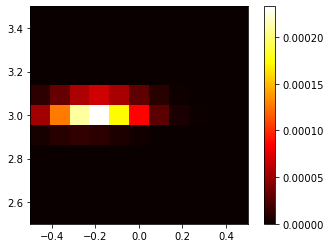

In [547]:
rewards = torch_posterior_numerator(XY, thetabiases).view(11, 11).detach().numpy()
plt.imshow(rewards, cmap='hot', interpolation='nearest',
          extent=[-0.5, 0.5, 2.5, 3.5])
plt.colorbar()

In [557]:
# Posterior as per GFN
thetas = torch.FloatTensor([[theta] for theta in thetaS])
thetaflows = torch.exp(F(XY, thetas).view(11).detach())
thetaflows /= thetaflows.sum()

In [563]:
fprobs = torch.exp(F.fprob(XY, thetabiases).view(11, 11).detach())

tensor([6.3311e-14, 7.2747e-13, 3.5175e-10, 3.4165e-06, 4.3440e-02, 2.9352e-01,
        1.4189e-03, 6.9373e-06, 3.0545e-08, 1.3411e-10, 5.8733e-13],
       dtype=torch.float64)